In [8]:
# Pneumonia Detection from Chest X-rays using Fine-tuned VGG16
# This notebook fine-tunes a pretrained VGG16 model on chest X-ray images to detect pneumonia

# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [2]:


# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Upload kaggle.json from your local machine
from google.colab import files
files.upload()  # Upload your kaggle.json file

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Create a directory for the dataset
!mkdir -p chest-xray-data
!unzip chest-xray-pneumonia.zip -d chest-xray-data

# !kaggle datasets download -d "Suzaan Khan C" "paultimothymooney/chest-xray-pneumonia"


# Create a directory for saving trained models
!mkdir -p /content/trained_models

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest-xray-data/chest_xray/train/NO

In [3]:
# Define paths for the dataset

dataset_path = '/content/chest-xray-data/chest_xray'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

Total training normal images: 1341
Total training pneumonia images: 3875
Total validation normal images: 8
Total validation pneumonia images: 8
Total test normal images: 234
Total test pneumonia images: 390


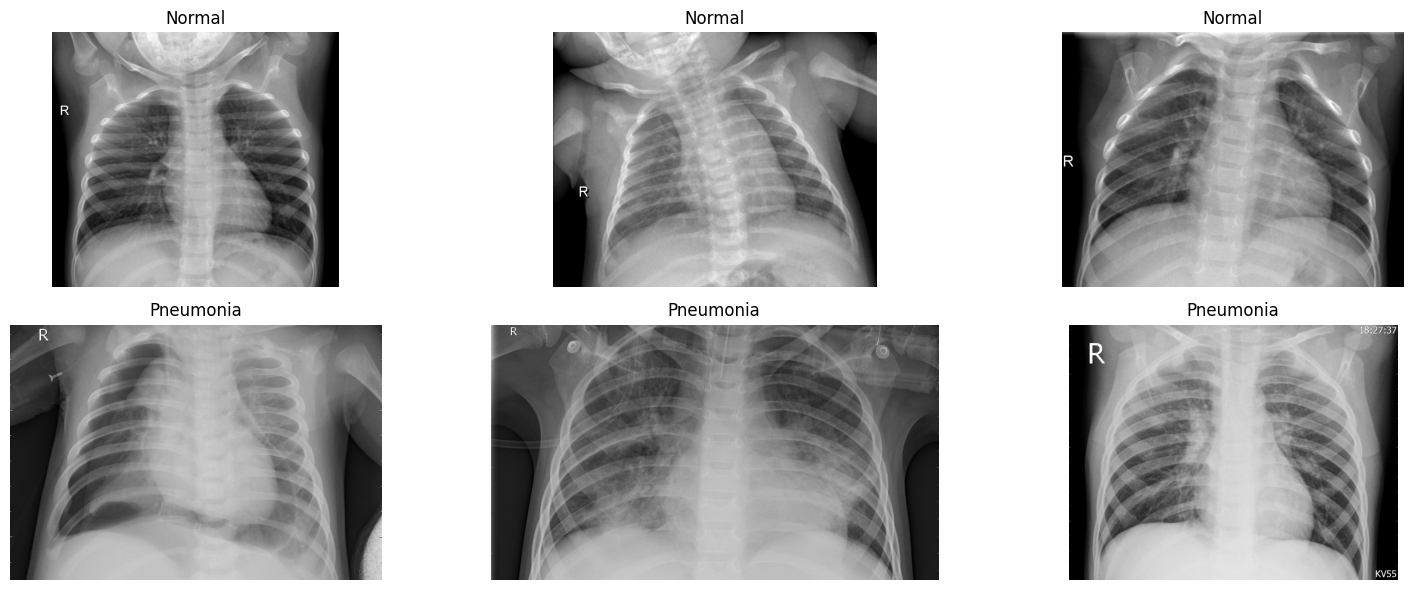

In [4]:
# Check the number of images in each directory
print('Total training normal images:', len(os.listdir(os.path.join(train_dir, 'NORMAL'))))
print('Total training pneumonia images:', len(os.listdir(os.path.join(train_dir, 'PNEUMONIA'))))
print('Total validation normal images:', len(os.listdir(os.path.join(val_dir, 'NORMAL'))))
print('Total validation pneumonia images:', len(os.listdir(os.path.join(val_dir, 'PNEUMONIA'))))
print('Total test normal images:', len(os.listdir(os.path.join(test_dir, 'NORMAL'))))
print('Total test pneumonia images:', len(os.listdir(os.path.join(test_dir, 'PNEUMONIA'))))

# Visualize some images from the dataset
plt.figure(figsize=(16, 6))

# Plot normal samples
for i in range(3):
    plt.subplot(2, 3, i+1)
    normal_img = random.choice(os.listdir(os.path.join(train_dir, 'NORMAL')))
    img = Image.open(os.path.join(train_dir, 'NORMAL', normal_img))
    plt.imshow(img, cmap='gray')
    plt.title('Normal')
    plt.axis('off')

# Plot pneumonia samples
for i in range(3):
    plt.subplot(2, 3, i+4)
    pneumonia_img = random.choice(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
    img = Image.open(os.path.join(train_dir, 'PNEUMONIA', pneumonia_img))
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Define image dimensions and parameters
img_width, img_height = 224, 224
batch_size = 128

# Create data generators with validation_split and class balancing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.22  # Use 20% of training data for validation
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Create data generators with class balancing
print("Creating balanced data generators...")

# Calculate class weights to handle class imbalance
total_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
total_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_samples = total_normal + total_pneumonia

# Compute class weights inversely proportional to class frequencies
weight_for_normal = (1 / total_normal) * (total_samples / 2.0)
weight_for_pneumonia = (1 / total_pneumonia) * (total_samples / 2.0)

class_weights = {0: weight_for_normal, 1: weight_for_pneumonia}
print(f"Class weights - Normal: {weight_for_normal:.4f}, Pneumonia: {weight_for_pneumonia:.4f}")


Creating balanced data generators...
Class weights - Normal: 1.9448, Pneumonia: 0.6730


In [6]:

# Use training data with validation split
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print(f"Training generator found {train_generator.samples} samples")
print(f"Validation generator found {validation_generator.samples} samples")
print(f"Test generator found {test_generator.samples} samples")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 4069 images belonging to 2 classes.
Found 1147 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training generator found 4069 samples
Validation generator found 1147 samples
Test generator found 624 samples
Found 624 images belonging to 2 classes.


In [ ]:
!pip install torchinfo torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torchvision
from torchinfo import summary

vgg = torchvision.models.vgg16(pretrained=True)

summary(vgg, input_size=(1,3,244,244))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 118MB/s] 


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 1000]                 --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         1,792
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         36,928
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        73,856
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        147,584
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]          29

In [7]:
# Load pretrained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Display the VGG16 model architecture
print("VGG16 Base Model Architecture:")
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
VGG16 Base Model Architecture:
Layer 0: input_layer, Trainable: True
Layer 1: block1_conv1, Trainable: True
Layer 2: block1_conv2, Trainable: True
Layer 3: block1_pool, Trainable: True
Layer 4: block2_conv1, Trainable: True
Layer 5: block2_conv2, Trainable: True
Layer 6: block2_pool, Trainable: True
Layer 7: block3_conv1, Trainable: True
Layer 8: block3_conv2, Trainable: True
Layer 9: block3_conv3, Trainable: True
Layer 10: block3_pool, Trainable: True
Layer 11: block4_conv1, Trainable: True
Layer 12: block4_conv2, Trainable: True
Layer 13: block4_conv3, Trainable: True
Layer 14: block4_pool, Trainable: True
Layer 15: block5_conv1, Trainable: True
Layer 16: block5_conv2, Trainable: True
Layer 17: block5_conv3, Trainable: True
Layer 18: block5_pool, Trainable: True


In [10]:

# Freeze all the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the final model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,771,457 (60.16 MB)

 Trainable params: 1,053,697 (4.02 MB)

 Non-trainable params: 14,717,760 (56.14 MB)

In [11]:

# Define callbacks
checkpoint = ModelCheckpoint(
    '/content/trained_models/vgg16_pneumonia_model_epoch_{epoch:02d}.h5',
    monitor='val_accuracy',
    save_best_only=False,
    save_freq=5,  # Save every 10 epochs
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [12]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

Steps per epoch: 31
Validation steps: 8


In [13]:
# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights  # Apply class weights during training
)

# Plot training history
plt.figure(figsize=(16, 6))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4840 - loss: 0.9962
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


 9/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5311 - loss: 0.8708
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


14/31 ━━━━━━━━━━━━━━━━━━━━ 1:10 4s/step - accuracy: 0.5717 - loss: 0.7867
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


19/31 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.6030 - loss: 0.7272
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


24/31 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6259 - loss: 0.6851
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


29/31 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6442 - loss: 0.6529
Epoch 1: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_01.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.6536 - loss: 0.6372 - val_accuracy: 0.4570 - val_loss: 1.6647 - learning_rate: 1.0000e-04
Epoch 2/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 14s 500ms/step - accuracy: 0.7812 - loss: 0.3521

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.7812 - loss: 0.3521 - val_accuracy: 0.4697 - val_loss: 1.6207 - learning_rate: 1.0000e-04
Epoch 3/50
 2/31 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.8516 - loss: 0.2634
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


 7/31 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8410 - loss: 0.2885 
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


12/31 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8409 - loss: 0.2892
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


17/31 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8417 - loss: 0.2882
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


22/31 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8435 - loss: 0.2879
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


27/31 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.8444 - loss: 0.2886
Epoch 3: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_03.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.8451 - loss: 0.2892 - val_accuracy: 0.7070 - val_loss: 0.7242 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8672 - loss: 0.2374 - val_accuracy: 0.7109 - val_loss: 0.7356 - learning_rate: 1.0000e-04
Epoch 5/50

Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


 5/31 ━━━━━━━━━━━━━━━━━━━━ 1:00 2s/step - accuracy: 0.8803 - loss: 0.2297
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


10/31 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8751 - loss: 0.2436
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


15/31 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8717 - loss: 0.2499
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


20/31 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8709 - loss: 0.2529
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


25/31 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.8711 - loss: 0.2537
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


30/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8715 - loss: 0.2532
Epoch 5: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_05.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.8718 - loss: 0.2529 - val_accuracy: 0.7979 - val_loss: 0.5264 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8984 - loss: 0.1854 - val_accuracy: 0.8076 - val_loss: 0.5112 - learning_rate: 1.0000e-04
Epoch 7/50
 3/31 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8763 - loss: 0.2917
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


 8/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8833 - loss: 0.2704
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


13/31 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8868 - loss: 0.2608
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


18/31 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8893 - loss: 0.2537
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


23/31 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8918 - loss: 0.2475
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


28/31 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8931 - loss: 0.2435
Epoch 7: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_07.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8940 - loss: 0.2412 - val_accuracy: 0.8818 - val_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8672 - loss: 0.2857 - val_accuracy: 0.8818 - val_loss: 0.3430 - learning_rate: 1.0000e-04
Epoch 9/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 1:58 4s/step - accuracy: 0.9375 - loss: 0.1510
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


 6/31 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.8998 - loss: 0.1902
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


11/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8985 - loss: 0.1995
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


16/31 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8982 - loss: 0.2005
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


21/31 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8998 - loss: 0.1991
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


26/31 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9016 - loss: 0.1987
Epoch 9: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_09.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9031 - loss: 0.1999 - val_accuracy: 0.8945 - val_loss: 0.3067 - learning_rate: 1.0000e-04
Epoch 10/50

Epoch 10: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_10.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9141 - loss: 0.2414 - val_accuracy: 0.8906 - val_loss: 0.3515 - learning_rate: 1.0000e-04
Epoch 11/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9243 - loss: 0.1645
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


 9/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9208 - loss: 0.1763
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


14/31 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9200 - loss: 0.1801
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


19/31 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9204 - loss: 0.1807
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


24/31 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9199 - loss: 0.1823
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


29/31 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9198 - loss: 0.1831
Epoch 11: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_11.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9199 - loss: 0.1832 - val_accuracy: 0.9160 - val_loss: 0.2517 - learning_rate: 1.0000e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 710ms/step - accuracy: 0.9297 - loss: 0.1745 - val_accuracy: 0.9014 - val_loss: 0.2899 - learning_rate: 1.0000e-04
Epoch 13/50
 2/31 ━━━━━━━━━━━━━━━━━━━━ 1:07 2s/step - accuracy: 0.9453 - loss: 0.1741
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


 7/31 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9324 - loss: 0.1943 
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


12/31 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.9280 - loss: 0.1950
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


17/31 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9276 - loss: 0.1902
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


22/31 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9280 - loss: 0.1854
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


27/31 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9285 - loss: 0.1818 
Epoch 13: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_13.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9291 - loss: 0.1789 - val_accuracy: 0.9150 - val_loss: 0.2792 - learning_rate: 1.0000e-04
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 703ms/step - accuracy: 0.9062 - loss: 0.1347 - val_accuracy: 0.8887 - val_loss: 0.3073 - learning_rate: 1.0000e-04
Epoch 15/50

Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


 5/31 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.9447 - loss: 0.1515
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


10/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9395 - loss: 0.1660
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


15/31 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9369 - loss: 0.1704
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


20/31 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9358 - loss: 0.1701
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


25/31 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9353 - loss: 0.1690
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


30/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9355 - loss: 0.1676
Epoch 15: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_15.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9355 - loss: 0.1673 - val_accuracy: 0.8916 - val_loss: 0.3194 - learning_rate: 1.0000e-04
Epoch 16/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - accuracy: 0.9219 - loss: 0.2012
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step - accuracy: 0.9219 - loss: 0.2012 - val_accuracy: 0.9023 - val_loss: 0.3284 - learning_rate: 1.0000e-04
Epoch 17/50
 3/31 ━━━━━━━━━━━━━━━━━━━━ 1:19 3s/step - accuracy: 0.9427 - loss: 0.1500
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


 8/31 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.9362 - loss: 0.1495
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


13/31 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9360 - loss: 0.1485
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


18/31 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.9359 - loss: 0.1495
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


23/31 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9356 - loss: 0.1502
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


28/31 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.9357 - loss: 0.1504 
Epoch 17: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_17.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9359 - loss: 0.1506 - val_accuracy: 0.9072 - val_loss: 0.2999 - learning_rate: 2.0000e-05
Epoch 18/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 724ms/step - accuracy: 0.9453 - loss: 0.1752 - val_accuracy: 0.9160 - val_loss: 0.2647 - learning_rate: 2.0000e-05
Epoch 19/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2:00 4s/step - accuracy: 0.9062 - loss: 0.1769
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


 6/31 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9146 - loss: 0.1706
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


11/31 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9179 - loss: 0.1751
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


16/31 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9218 - loss: 0.1727
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


21/31 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9248 - loss: 0.1692
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


26/31 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9268 - loss: 0.1666
Epoch 19: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_19.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9287 - loss: 0.1640 - val_accuracy: 0.9307 - val_loss: 0.2602 - learning_rate: 2.0000e-05
Epoch 20/50

Epoch 20: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_20.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9375 - loss: 0.1348 - val_accuracy: 0.9170 - val_loss: 0.2364 - learning_rate: 2.0000e-05
Epoch 21/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9451 - loss: 0.1249
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


 9/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9434 - loss: 0.1250
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


14/31 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9425 - loss: 0.1248
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


19/31 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9427 - loss: 0.1247
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


24/31 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9430 - loss: 0.1257
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


29/31 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.9435 - loss: 0.1270
Epoch 21: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_21.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9436 - loss: 0.1279 - val_accuracy: 0.9355 - val_loss: 0.2152 - learning_rate: 2.0000e-05
Epoch 22/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 731ms/step - accuracy: 0.9219 - loss: 0.1684 - val_accuracy: 0.9268 - val_loss: 0.2298 - learning_rate: 2.0000e-05
Epoch 23/50
 2/31 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.9414 - loss: 0.1801  
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


 7/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9364 - loss: 0.1765
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


12/31 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9361 - loss: 0.1751
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


17/31 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9373 - loss: 0.1705
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


22/31 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9379 - loss: 0.1667
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


27/31 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9384 - loss: 0.1647 
Epoch 23: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_23.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9391 - loss: 0.1628 - val_accuracy: 0.9287 - val_loss: 0.2001 - learning_rate: 2.0000e-05
Epoch 24/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9609 - loss: 0.1111 - val_accuracy: 0.9326 - val_loss: 0.2149 - learning_rate: 2.0000e-05
Epoch 25/50

Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


 5/31 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.9285 - loss: 0.1975
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


10/31 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9347 - loss: 0.1749
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


15/31 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9379 - loss: 0.1651
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


20/31 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9392 - loss: 0.1605
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


25/31 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9396 - loss: 0.1588
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


30/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9400 - loss: 0.1572
Epoch 25: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_25.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.9401 - loss: 0.1567 - val_accuracy: 0.9453 - val_loss: 0.1906 - learning_rate: 2.0000e-05
Epoch 26/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9844 - loss: 0.0671 - val_accuracy: 0.9287 - val_loss: 0.2066 - learning_rate: 2.0000e-05
Epoch 27/50
 3/31 ━━━━━━━━━━━━━━━━━━━━ 1:16 3s/step - accuracy: 0.9141 - loss: 0.1580
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


 8/31 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.9285 - loss: 0.1388
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


13/31 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9316 - loss: 0.1368
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


18/31 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9325 - loss: 0.1380
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


23/31 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9337 - loss: 0.1389
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


28/31 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9351 - loss: 0.1388
Epoch 27: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_27.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9360 - loss: 0.1388 - val_accuracy: 0.9395 - val_loss: 0.1934 - learning_rate: 2.0000e-05
Epoch 28/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 22s 733ms/step - accuracy: 0.9453 - loss: 0.1397 - val_accuracy: 0.9404 - val_loss: 0.1779 - learning_rate: 2.0000e-05
Epoch 29/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2:03 4s/step - accuracy: 0.9766 - loss: 0.0769
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


 6/31 ━━━━━━━━━━━━━━━━━━━━ 1:01 2s/step - accuracy: 0.9425 - loss: 0.1439
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


11/31 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9405 - loss: 0.1483
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


16/31 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.9404 - loss: 0.1456
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


21/31 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.9398 - loss: 0.1452
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


26/31 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9391 - loss: 0.1457
Epoch 29: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_29.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9388 - loss: 0.1460 - val_accuracy: 0.9502 - val_loss: 0.1587 - learning_rate: 2.0000e-05
Epoch 30/50

Epoch 30: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_30.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9766 - loss: 0.0610 - val_accuracy: 0.9502 - val_loss: 0.1778 - learning_rate: 2.0000e-05
Epoch 31/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 1:05 2s/step - accuracy: 0.9562 - loss: 0.1256
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


 9/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9440 - loss: 0.1448
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


14/31 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9422 - loss: 0.1494
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


19/31 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9411 - loss: 0.1532
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


24/31 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9408 - loss: 0.1545
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


29/31 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9407 - loss: 0.1547
Epoch 31: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_31.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9409 - loss: 0.1542 - val_accuracy: 0.9541 - val_loss: 0.1548 - learning_rate: 2.0000e-05
Epoch 32/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9453 - loss: 0.1014 - val_accuracy: 0.9482 - val_loss: 0.1754 - learning_rate: 2.0000e-05
Epoch 33/50
 2/31 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - accuracy: 0.9434 - loss: 0.1196
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


 7/31 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.9318 - loss: 0.1368
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


12/31 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9336 - loss: 0.1386
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


17/31 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.9359 - loss: 0.1388
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


22/31 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.9374 - loss: 0.1390
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


27/31 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9383 - loss: 0.1397 
Epoch 33: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_33.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.9391 - loss: 0.1397 - val_accuracy: 0.9521 - val_loss: 0.1680 - learning_rate: 2.0000e-05
Epoch 34/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9141 - loss: 0.1775 - val_accuracy: 0.9502 - val_loss: 0.1688 - learning_rate: 2.0000e-05
Epoch 35/50

Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


 5/31 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.9496 - loss: 0.1073
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


10/31 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9474 - loss: 0.1204
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


15/31 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9481 - loss: 0.1208
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


20/31 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9484 - loss: 0.1217
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


25/31 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9483 - loss: 0.1231
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


30/31 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9480 - loss: 0.1244
Epoch 35: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_35.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 101s 3s/step - accuracy: 0.9479 - loss: 0.1248 - val_accuracy: 0.9434 - val_loss: 0.1688 - learning_rate: 2.0000e-05
Epoch 36/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 15s 507ms/step - accuracy: 0.9453 - loss: 0.1401
Epoch 36: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9453 - loss: 0.1401 - val_accuracy: 0.9404 - val_loss: 0.1651 - learning_rate: 2.0000e-05
Epoch 37/50
 3/31 ━━━━━━━━━━━━━━━━━━━━ 1:04 2s/step - accuracy: 0.9666 - loss: 0.1030
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


 8/31 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.9626 - loss: 0.1047
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


13/31 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9610 - loss: 0.1072
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


18/31 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9600 - loss: 0.1102
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


23/31 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9594 - loss: 0.1123
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


28/31 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9587 - loss: 0.1144
Epoch 37: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_37.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.9579 - loss: 0.1161 - val_accuracy: 0.9434 - val_loss: 0.1710 - learning_rate: 4.0000e-06
Epoch 38/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 763ms/step - accuracy: 0.9609 - loss: 0.0746 - val_accuracy: 0.9395 - val_loss: 0.1964 - learning_rate: 4.0000e-06
Epoch 39/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 21:15 43s/step - accuracy: 0.9766 - loss: 0.0714
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


 6/31 ━━━━━━━━━━━━━━━━━━━━ 1:02 2s/step - accuracy: 0.9572 - loss: 0.1008
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


11/31 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9543 - loss: 0.1094
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


16/31 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9531 - loss: 0.1120
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


21/31 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9526 - loss: 0.1138
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


26/31 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9522 - loss: 0.1152
Epoch 39: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_39.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9518 - loss: 0.1171 - val_accuracy: 0.9492 - val_loss: 0.1728 - learning_rate: 4.0000e-06
Epoch 40/50

Epoch 40: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_40.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9609 - loss: 0.1338 - val_accuracy: 0.9473 - val_loss: 0.1703 - learning_rate: 4.0000e-06
Epoch 41/50
 4/31 ━━━━━━━━━━━━━━━━━━━━ 1:03 2s/step - accuracy: 0.9658 - loss: 0.0861
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


 9/31 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9599 - loss: 0.1102
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


14/31 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9584 - loss: 0.1188
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


19/31 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.9567 - loss: 0.1248
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


24/31 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9548 - loss: 0.1292
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


29/31 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.9537 - loss: 0.1312
Epoch 41: saving model to /content/trained_models/vgg16_pneumonia_model_epoch_41.h5


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9534 - loss: 0.1316
Epoch 41: ReduceLROnPlateau reducing learning rate to 1e-06.
31/31 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.9533 - loss: 0.1318 - val_accuracy: 0.9443 - val_loss: 0.1746 - learning_rate: 4.0000e-06
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 31.


<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

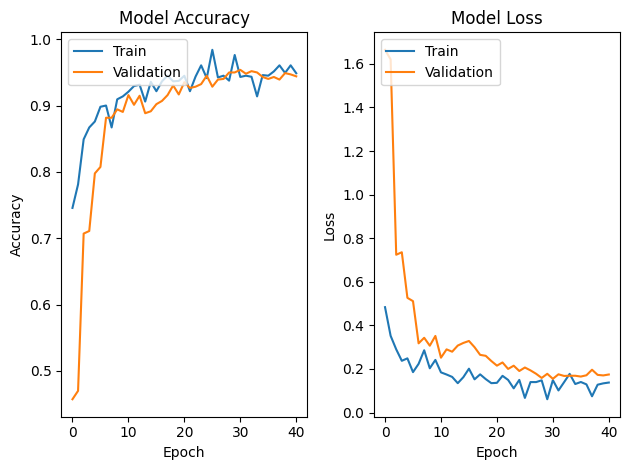

Final model saved successfully!
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.8991 - loss: 0.2591
Test Accuracy: 89.42%
Test Loss: 0.2888


In [14]:



# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Save the final model
model.save('/content/trained_models/vgg16_pneumonia_final_model.h5')
print("Final model saved successfully!")

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 969ms/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.83      0.90      0.86       234
   PNEUMONIA       0.94      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.90      0.89       624
weighted avg       0.90      0.89      0.90       624



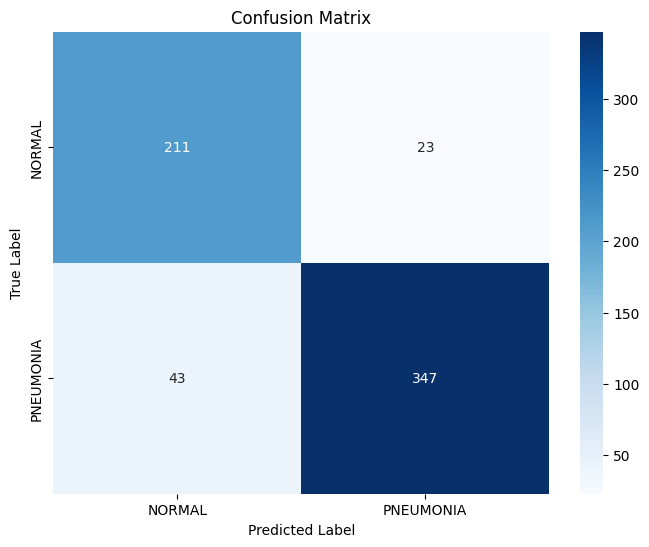

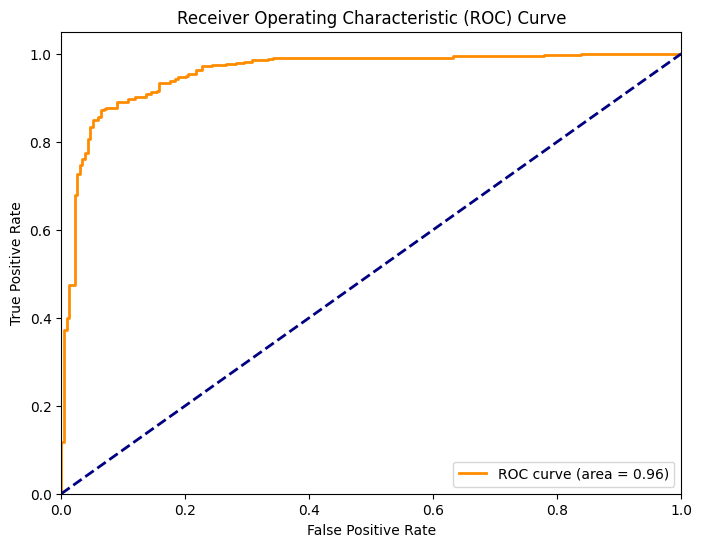

In [15]:

# Get predictions for test data
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int)
y_true = test_generator.classes

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


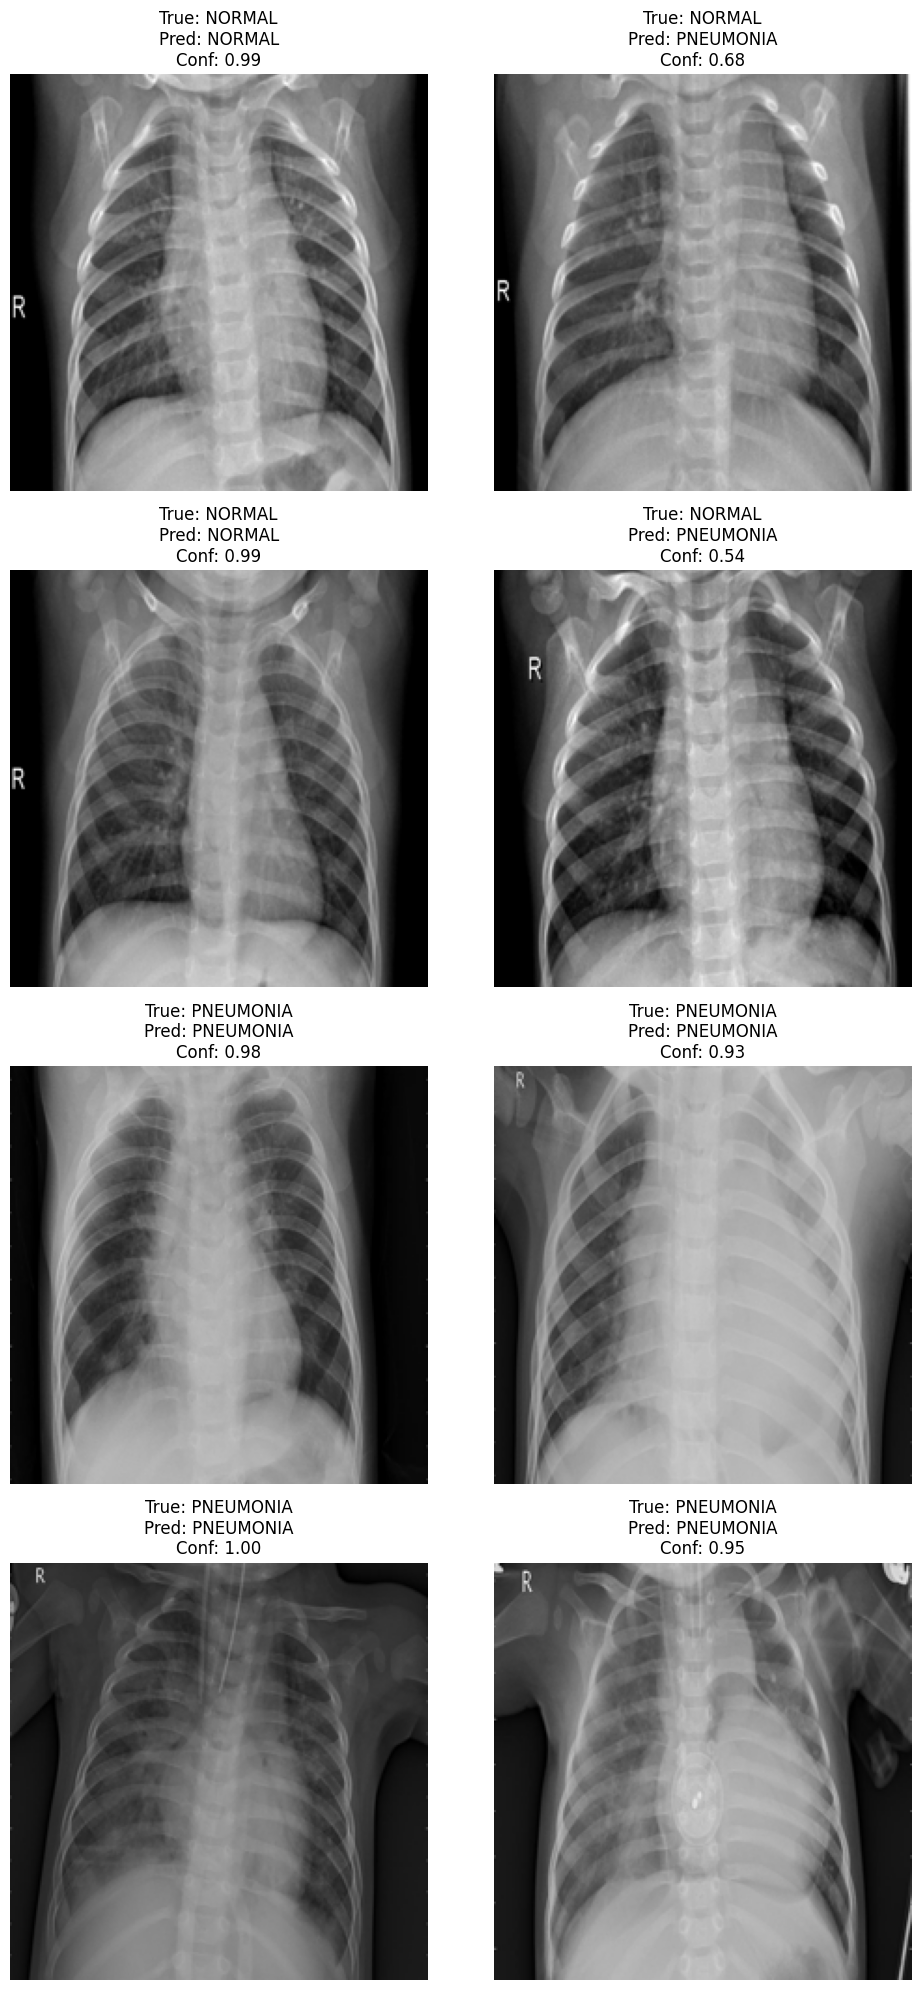

In [18]:
import math
# Visualize some test predictions
def visualize_predictions(num_images=8):
    test_dir_normal = os.path.join(test_dir, 'NORMAL')
    test_dir_pneumonia = os.path.join(test_dir, 'PNEUMONIA')

    # Get random samples from each class
    normal_samples = random.sample(os.listdir(test_dir_normal), num_images//2)
    pneumonia_samples = random.sample(os.listdir(test_dir_pneumonia), num_images//2)

    # plt.figure(figsize=(16, 12))

    total_images = len(normal_samples) + len(pneumonia_samples)

    cols = 2
    rows = math.ceil(total_images / cols)

    plt.figure(figsize=(cols * 5, rows * 5))

    # Plot normal samples
    for i, img_name in enumerate(normal_samples):
        img_path = os.path.join(test_dir_normal, img_name)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_width, img_height))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)[0][0]
        predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: NORMAL\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')

    # Plot pneumonia samples
    for i, img_name in enumerate(pneumonia_samples):
        img_path = os.path.join(test_dir_pneumonia, img_name)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_width, img_height))
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        prediction = model.predict(img_array)[0][0]
        # print("This is iteration " + str(i))
        # print(prediction)
        predicted_class = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
        confidence = prediction if prediction > 0.5 else 1 - prediction

        plt.subplot(rows, cols, i+num_images//2+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: PNEUMONIA\nPred: {predicted_class}\nConf: {confidence:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize predictions on test images
visualize_predictions(num_images=8)